In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, roc_curve, auc, classification_report, precision_recall_curve
from sklearn.ensemble import GradientBoostingClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import joblib

2024-08-26 16:36:38.545969: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-26 16:36:38.762684: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-26 16:36:38.974093: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-26 16:36:39.138478: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-26 16:36:39.183662: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-26 16:36:39.484583: I tensorflow/core/platform/cpu_feature_gu

In [2]:
# Read csv data file
df = pd.read_csv("../data/internet_service_churn.csv")

# drop user id
df.drop('id', axis=1, inplace=True)

print(df.shape)

# Data preview
print("\nThe first 5 rows of data:")
print(df.head())

(72274, 10)

The first 5 rows of data:
   is_tv_subscriber  is_movie_package_subscriber  subscription_age  bill_avg  \
0                 1                            0             11.95        25   
1                 0                            0              8.22         0   
2                 1                            0              8.91        16   
3                 0                            0              6.87        21   
4                 0                            0              6.39         0   

   reamining_contract  service_failure_count  download_avg  upload_avg  \
0                0.14                      0           8.4         2.3   
1                 NaN                      0           0.0         0.0   
2                0.00                      0          13.7         0.9   
3                 NaN                      1           0.0         0.0   
4                 NaN                      0           0.0         0.0   

   download_over_limit  churn  
0  

In [3]:
# Check if there are any variables with missing values
missing_values = df.isna().sum()
print("Number of missing values in each column:")
print(missing_values)

Number of missing values in each column:
is_tv_subscriber                   0
is_movie_package_subscriber        0
subscription_age                   0
bill_avg                           0
reamining_contract             21572
service_failure_count              0
download_avg                     381
upload_avg                       381
download_over_limit                0
churn                              0
dtype: int64


> # Filling in missing values

In [4]:
# NaN in 'reamining_contract' means no contract, so fill with 0
df.fillna({'reamining_contract': 0}, inplace=True)
   
# NaN in the 'download_avg' and 'upload_avg' columns indicates inactivity, so fill with 0
df.fillna({'download_avg': 0}, inplace=True)
df.fillna({'upload_avg': 0}, inplace=True)

# Check if there are still NaNs in the columns
print(df.isna().sum())

is_tv_subscriber               0
is_movie_package_subscriber    0
subscription_age               0
bill_avg                       0
reamining_contract             0
service_failure_count          0
download_avg                   0
upload_avg                     0
download_over_limit            0
churn                          0
dtype: int64


Number of rows with with all features equal zero: 62


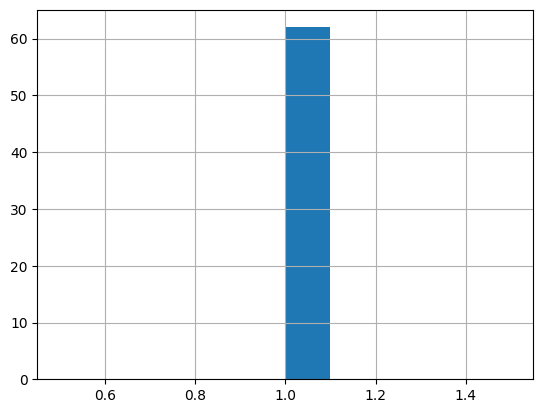

In [5]:
# Check again if there are any rows with all zeros for feature values (i.e. excluding churn)
has_zero_rows = (df.drop(columns=["churn"]) == 0).all(axis=1)
print("Number of rows with with all features equal zero:", df[has_zero_rows].shape[0])
df[has_zero_rows]["churn"].hist()
# Remove the identified rows (0 for all features and churn doesn't make sense)
df = df[~has_zero_rows]

> # Data Exploration

In [6]:
# Calculate descriptive statistics
def show_statistics(df):    
    desc_stats = pd.DataFrame({
        'Mean': df.mean(),
        'Standard Deviation': df.std(),
        'Median': df.median(),
        'Min': df.min(),
        'Max': df.max()
    })
    
    # Print the nicely formatted table
    print("Descriptive Statistics:")
    print(desc_stats.round(3))

In [7]:
show_statistics(df)

Descriptive Statistics:
                               Mean  Standard Deviation  Median   Min      Max
is_tv_subscriber              0.816               0.388    1.00  0.00     1.00
is_movie_package_subscriber   0.335               0.472    0.00  0.00     1.00
subscription_age              2.452               2.035    1.98 -0.02    12.80
bill_avg                     18.959              13.209   19.00  0.00   406.00
reamining_contract            0.503               0.670    0.00  0.00     2.92
service_failure_count         0.274               0.817    0.00  0.00    19.00
download_avg                 43.497              63.332   27.60  0.00  4415.20
upload_avg                    4.174               9.801    2.10  0.00   453.30
download_over_limit           0.208               0.998    0.00  0.00     7.00
churn                         0.554               0.497    1.00  0.00     1.00


In [6]:
# Negative values in subscription age (doesn't make sense) (one such row)
negative_sub_age = df["subscription_age"]<0
print("Number of rows with negative subscription_age: ", df[negative_sub_age].shape[0])
print(df[negative_sub_age])
# remove this row
df =df[~negative_sub_age]

Number of rows with negative subscription_age:  1
       is_tv_subscriber  is_movie_package_subscriber  subscription_age  \
69320                 0                            0             -0.02   

       bill_avg  reamining_contract  service_failure_count  download_avg  \
69320         0                0.08                      0          32.6   

       upload_avg  download_over_limit  churn  
69320         1.3                    0      1  


In [9]:
def plot_histograms(df, ncols):
    # Number of columns
    num_columns = df.shape[1]
    
    # Determine grid size (e.g., 2x2 for 4 columns)
    nrows = (num_columns + ncols - 1) // ncols  # Calculate rows needed
    
    # Create subplots
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 8))
    
    # Flatten the axes array to easily iterate over it
    axes = axes.flatten()
    
    # Plot each column in a separate subplot
    for i, col in enumerate(df.columns):
        sns.histplot(df[col], bins=20, kde=False, ax=axes[i])
        axes[i].set_title(f'{col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Frequency')
    
    # Remove any empty subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()

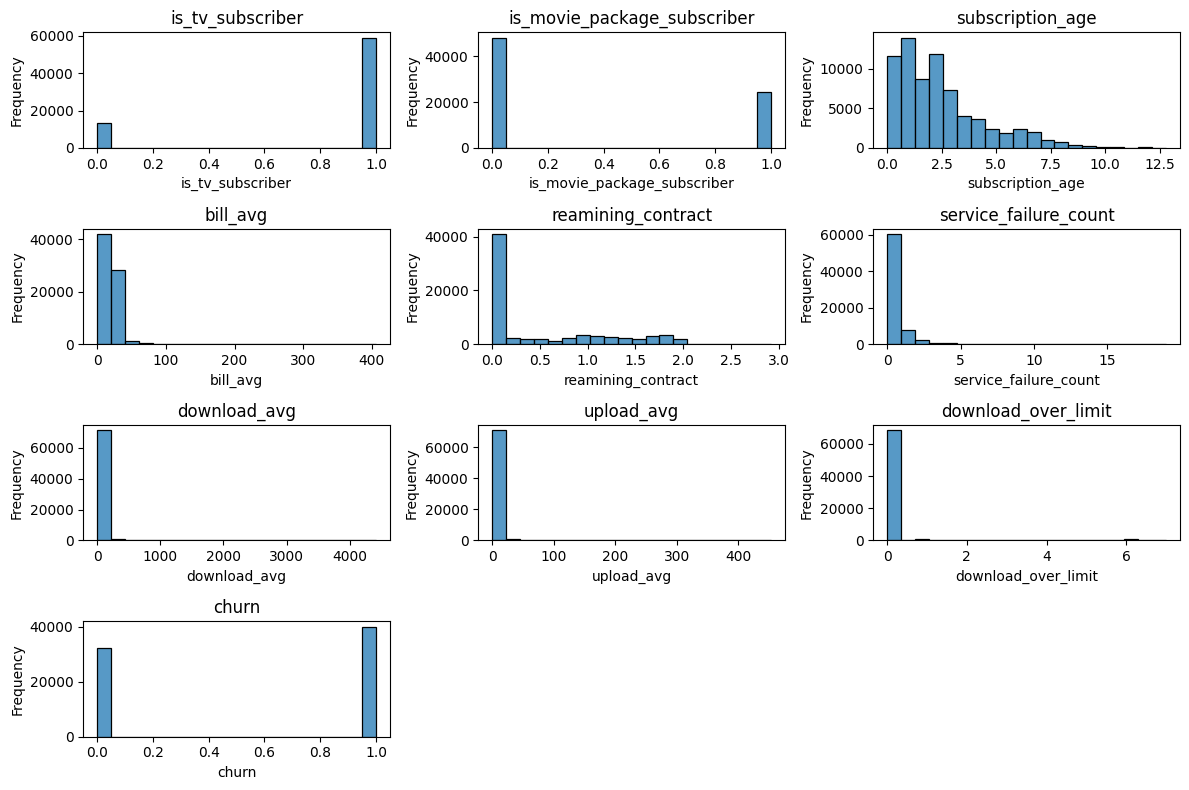

In [10]:
plot_histograms(df,ncols=3)

### Anomaly detection

In [7]:
from sklearn.ensemble import IsolationForest
# Initialize Isolation Forest
iso_forest = IsolationForest(contamination=0.05, random_state=42)

# Fit the model
df['anomaly'] = iso_forest.fit_predict(df)

In [8]:
# -1 indicates anomalies, 1 indicates normal points
anomalies = df[df['anomaly'] == -1]
normal_points = df[df['anomaly'] == 1]

anomalies.shape

(3611, 11)

In [14]:
show_statistics(normal_points)

Descriptive Statistics:
                               Mean  Standard Deviation  Median  Min     Max
is_tv_subscriber              0.829               0.377    1.00  0.0    1.00
is_movie_package_subscriber   0.331               0.471    0.00  0.0    1.00
subscription_age              2.434               1.994    1.98  0.0   12.80
bill_avg                     18.108               9.159   19.00  0.0  162.00
reamining_contract            0.490               0.660    0.00  0.0    2.92
service_failure_count         0.209               0.598    0.00  0.0   10.00
download_avg                 38.818              42.323   26.40  0.0  532.60
upload_avg                    3.417               5.448    2.00  0.0  392.70
download_over_limit           0.167               0.876    0.00  0.0    7.00
churn                         0.560               0.496    1.00  0.0    1.00
anomaly                       1.000               0.000    1.00  1.0    1.00


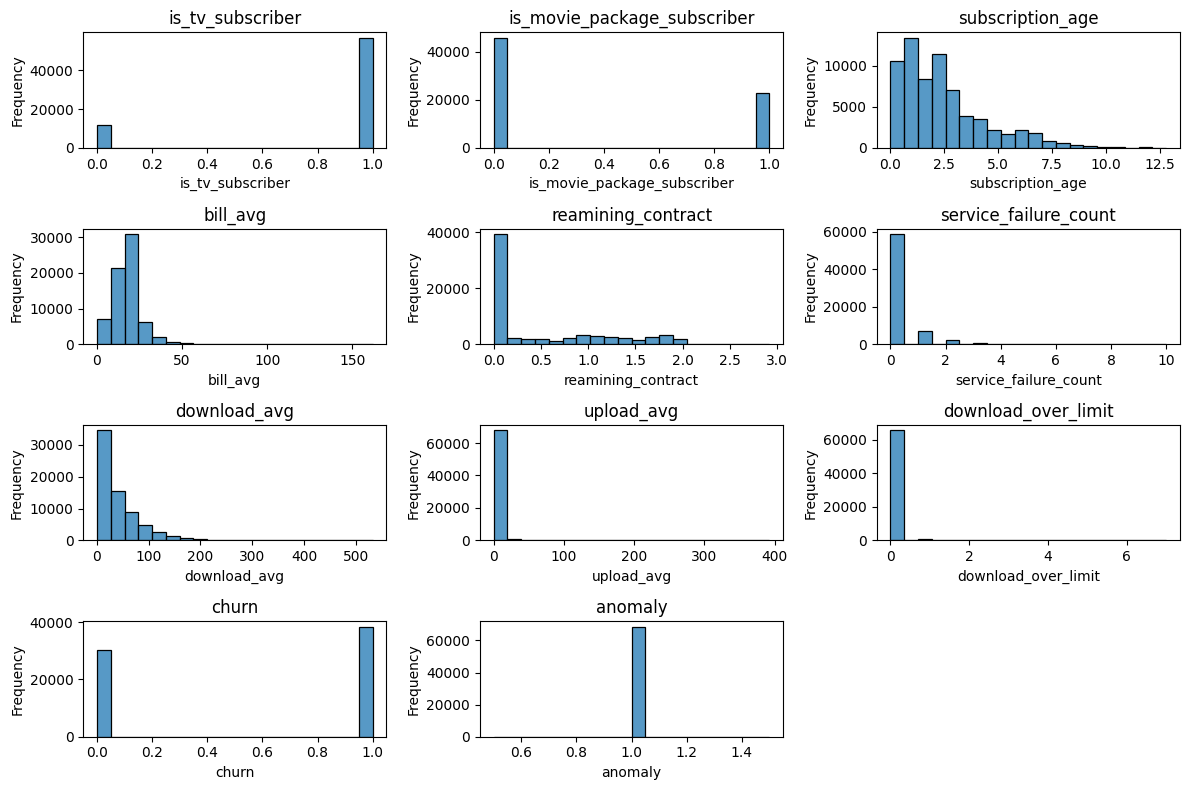

In [15]:
plot_histograms(normal_points, ncols=3)

# Data standarization

In [9]:
# select not anomal data for further processing
df = normal_points.drop(columns=['anomaly'])
print(df.shape)

# Selection of features for normalization
features_to_scale = ['subscription_age', 'bill_avg', 'reamining_contract', 'service_failure_count', 'download_avg', 'upload_avg']

# Feature normalization
scaler = StandardScaler()
df[features_to_scale] = scaler.fit_transform(df[features_to_scale])
print(df.head())

(68600, 10)
   is_tv_subscriber  is_movie_package_subscriber  subscription_age  bill_avg  \
0                 1                            0          4.772072  0.752809   
1                 0                            0          2.901544 -1.976714   
2                 1                            0          3.247566 -0.229819   
3                 0                            0          2.224543  0.316085   
4                 0                            0          1.983831 -1.976714   

   reamining_contract  service_failure_count  download_avg  upload_avg  \
0           -0.530104              -0.349127     -0.718409   -0.204942   
1           -0.742240              -0.349127     -0.916814   -0.627008   
2           -0.742240              -0.349127     -0.593224   -0.461851   
3           -0.742240               1.323016     -0.916814   -0.627008   
4           -0.742240              -0.349127     -0.916814   -0.627008   

   download_over_limit  churn  
0                    0      0 

In [14]:
# save scaler to file
joblib.dump(scaler, '../models/scaler.pkl')

['../models/scaler.pkl']

# Correlation matrix

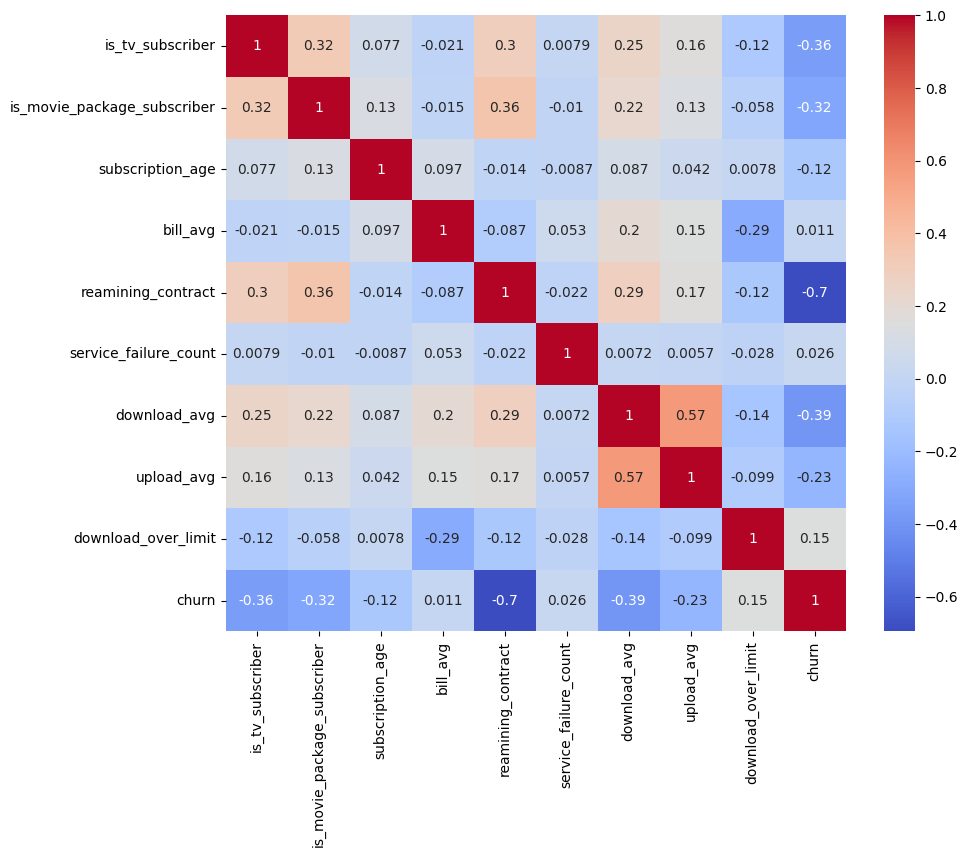

In [17]:
corr = df.corr()

# Visualization of correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

<Axes: xlabel='reamining_contract', ylabel='download_avg'>

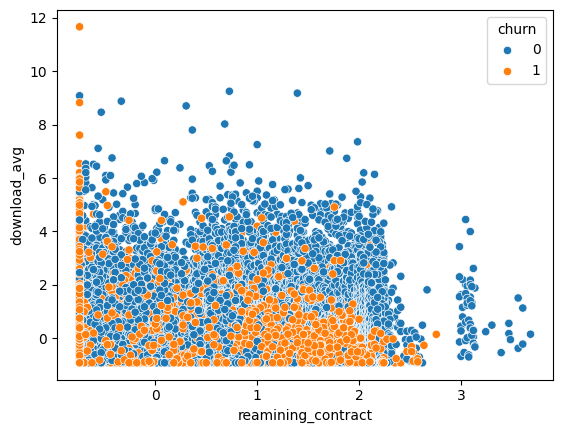

In [18]:
sns.scatterplot(x='reamining_contract', y='download_avg', hue='churn', data=df)

# Division into training and test sets

In [10]:
# Splitting data into features (X) and target variable (y)
X = df.drop(columns=['churn'])
y = df['churn']

In [11]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=666)

# Supervised Machine Learning Models

In [12]:
# Support Vector Machine (SVM) with rbf kernel
svm_model = SVC(kernel='rbf', probability=True, random_state=42)

# Random Forest Model
rf_model = RandomForestClassifier(random_state=42)

# Logistic Regression Model (simpler model for comparison)
lr_model = LogisticRegression(random_state=42)

# Define the Gradient Boosting model
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

## Training models with cross validation

In [13]:
# Perform Cross-Validation and print results
def perform_cross_validation(model, X, y, cv=5):
    print(f"Performing cross-validation for {model.__class__.__name__}...")
    # Cross-validation for accuracy
    accuracy = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
    
    print(f"Cross-Validation Results for {model.__class__.__name__}:")
    print(f"Accuracy: {np.mean(accuracy) * 100:.2f} +/- {np.std(accuracy) * 100:.2f} %")
    print("-" * 50)

### SVM model

In [22]:
# Perform Cross-Validation SVM model
perform_cross_validation(svm_model, X_train, y_train)

Performing cross-validation for SVC...


In [22]:
# Train the SVM model with SVC implementation
svm_model.fit(X_train, y_train)

SVC(probability=True, random_state=42)

### Random Forest Classifier

In [ ]:
# Perform Cross-Validation Random Forest
perform_cross_validation(rf_model, X_train, y_train)

Performing cross-validation for RandomForestClassifier...
Cross-Validation Results for RandomForestClassifier:
Accuracy: 94.33 +/- 0.21 %
--------------------------------------------------


In [14]:
# Train the Random Forest model
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

### Logistic Regression Classifier

In [ ]:
# Perform Cross-Validation Logistic Regression
perform_cross_validation(lr_model, X_train, y_train)

Performing cross-validation for LogisticRegression...
Cross-Validation Results for LogisticRegression:
Accuracy: 87.84 +/- 0.11 %
--------------------------------------------------


In [16]:
# Define the parameter grid to search for LogisticRegression
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],            # Regularization strength
    'penalty': ['l1', 'l2'],                 # Regularization type
    'solver': ['liblinear', 'saga'], 
    'max_iter': [100, 200, 300]              # Maximum number of iterations
}

# Set up GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(lr_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the GridSearchCV to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters
print("Best Parameters:", grid_search.best_params_)

# Get the best model
lr_model = grid_search.best_estimator_
print("Best Model:", lr_model)

/home/rafal/.local/share/virtualenvs/project3_datascience-OFn4O-rq/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/rafal/.local/share/virtualenvs/project3_datascience-OFn4O-rq/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/rafal/.local/share/virtualenvs/project3_datascience-OFn4O-rq/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/rafal/.local/share/virtualenvs/project3_datascience-OFn4O-rq/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/rafal/.local/share/virtualenvs/project3_datascience-OFn4O-rq/lib/pytho

Best Parameters: {'C': 1, 'max_iter': 200, 'penalty': 'l1', 'solver': 'saga'}
Best Model: LogisticRegression(C=1, max_iter=200, penalty='l1', random_state=42,
                   solver='saga')


In [17]:
# Train the Logistic Regression model
lr_model.fit(X_train, y_train)

LogisticRegression(C=1, max_iter=200, penalty='l1', random_state=42,
                   solver='saga')

### Gradient Boosting Classifier

In [ ]:
# Perform Cross-Validation Gradient Boosting
perform_cross_validation(gb_model, X_train, y_train)

Performing cross-validation for GradientBoostingClassifier...
Cross-Validation Results for GradientBoostingClassifier:
Accuracy: 94.12 +/- 0.22 %
--------------------------------------------------


In [15]:
# Train the Gradient Boosting Classifier
gb_model.fit(X_train, y_train)

GradientBoostingClassifier(random_state=42)

## Model evaluation

In [23]:
def evaluate_model(model, X_test, y_test):
    model_name = model.__class__.__name__
    y_pred = model.predict(X_test)
    print(f"Evaluating {model_name}...")
    # Calculating metrics
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Displaying the results
    print(f"{model_name} Results:")
    print(f"Accuracy: {accuracy * 100:.1f}%")
    print(f"Recall: {recall * 100:.1f}%")
    print(f"Precision: {precision * 100:.1f}%")
    print(f"F1 Score: {f1 * 100:.1f}%")

    # Print full classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, digits=3))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

### Evaluate SVM Model

Evaluating SVC...
SVC Results:
Accuracy: 91.1%
Recall: 92.9%
Precision: 91.5%
F1 Score: 92.2%

Classification Report:
              precision    recall  f1-score   support

           0      0.906     0.888     0.897      5967
           1      0.915     0.929     0.922      7753

    accuracy                          0.911     13720
   macro avg      0.911     0.909     0.909     13720
weighted avg      0.911     0.911     0.911     13720



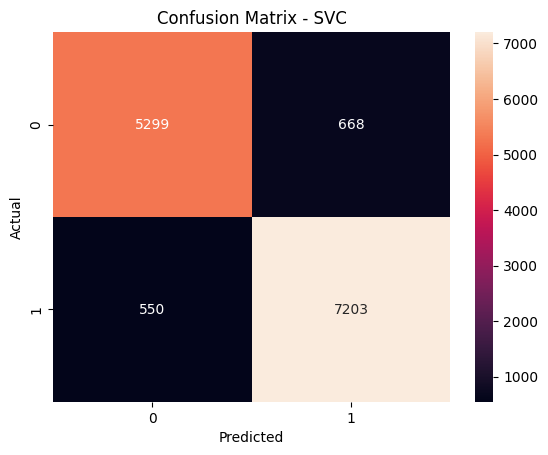

In [24]:
evaluate_model(svm_model, X_test, y_test)

In [ ]:
# Save the model to a file using joblib
joblib.dump(svm_model, '../models/support_vector_classifier.pkl')

['../models/support_vector_classifier.pkl']

### Evaluate Random Forest Model

Evaluating RandomForestClassifier...
RandomForestClassifier Results:
Accuracy: 94.4%
Recall: 93.8%
Precision: 96.1%
F1 Score: 94.9%

Classification Report:
              precision    recall  f1-score   support

           0      0.922     0.950     0.936      5967
           1      0.961     0.938     0.949      7753

    accuracy                          0.944     13720
   macro avg      0.942     0.944     0.943     13720
weighted avg      0.944     0.944     0.944     13720



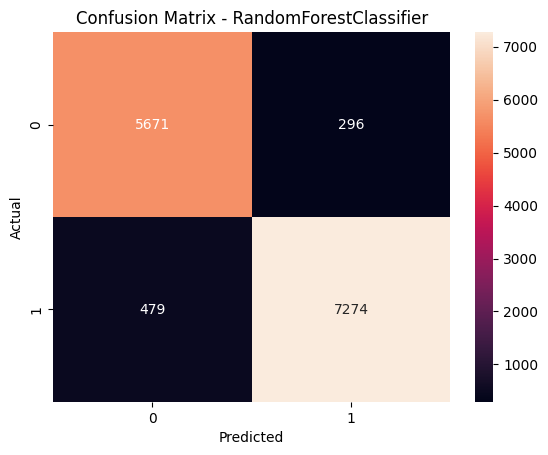

In [25]:
evaluate_model(rf_model, X_test, y_test)

In [ ]:
# Save the model to a file using joblib (compression enabled)
joblib.dump(rf_model, '../models/random_forest_classifier.pkl', compress=3)

['../models/random_forest_classifier.pkl']

#### Evaluate Logistic Regression Model

Evaluating LogisticRegression...
LogisticRegression Results:
Accuracy: 87.8%
Recall: 91.6%
Precision: 87.4%
F1 Score: 89.5%

Classification Report:
              precision    recall  f1-score   support

           0      0.884     0.829     0.855      5967
           1      0.874     0.916     0.895      7753

    accuracy                          0.878     13720
   macro avg      0.879     0.872     0.875     13720
weighted avg      0.878     0.878     0.878     13720



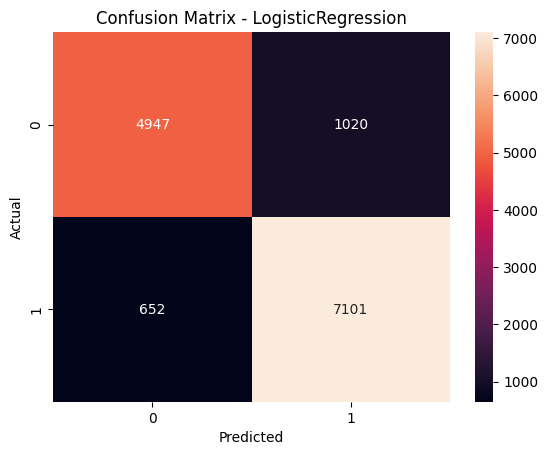

In [26]:
evaluate_model(lr_model, X_test, y_test)

In [ ]:
# Save the model to a file using joblib
joblib.dump(lr_model, '../models/logistic_regression_classifier.pkl')

['../models/logistic_regression_classifier.pkl']

### Evaluate Gradient Boosting Classifier

Evaluating GradientBoostingClassifier...
GradientBoostingClassifier Results:
Accuracy: 94.1%
Recall: 93.7%
Precision: 95.8%
F1 Score: 94.7%

Classification Report:
              precision    recall  f1-score   support

           0      0.920     0.947     0.933      5967
           1      0.958     0.937     0.947      7753

    accuracy                          0.941     13720
   macro avg      0.939     0.942     0.940     13720
weighted avg      0.942     0.941     0.941     13720



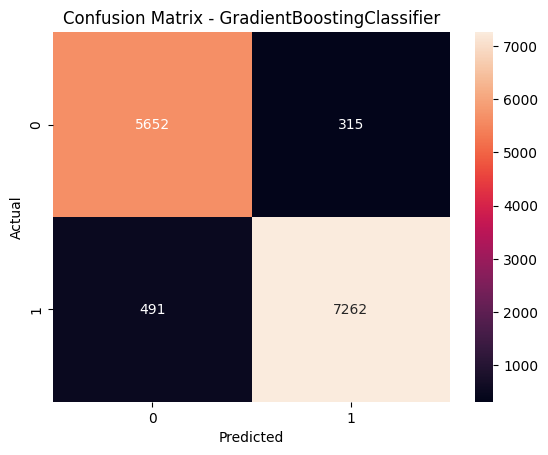

In [27]:
evaluate_model(gb_model, X_test, y_test)

In [ ]:
# Save the model to a file using joblib
joblib.dump(gb_model, '../models/gradient_boosting_classifier.pkl')

['../models/gradient_boosting_classifier.pkl']

## ROC and Precision-Recall curves

In [40]:
# Calculate the ROC curve and AUC
def plot_ROC_PR_curves(model):
    model_name = model.__class__.__name__
    print(f"model name: {model_name}")
    try:
        y_pred_prob = model.predict_proba(X_test)[:, 1]
    except AttributeError:
        y_pred_prob = model.predict(X_test)

    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    
    # Calculate the Precision-Recall curve
    precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
    
    # Create a figure with two subplots in one row
    plt.figure(figsize=(12, 5))
    
    # Subplot 1: ROC Curve
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    
    # Subplot 2: Precision-Recall Curve
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, color='blue', lw=2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    
    plt.tight_layout()  # Adjusts the spacing between plots to avoid overlap
    plt.show()

model name: RandomForestClassifier


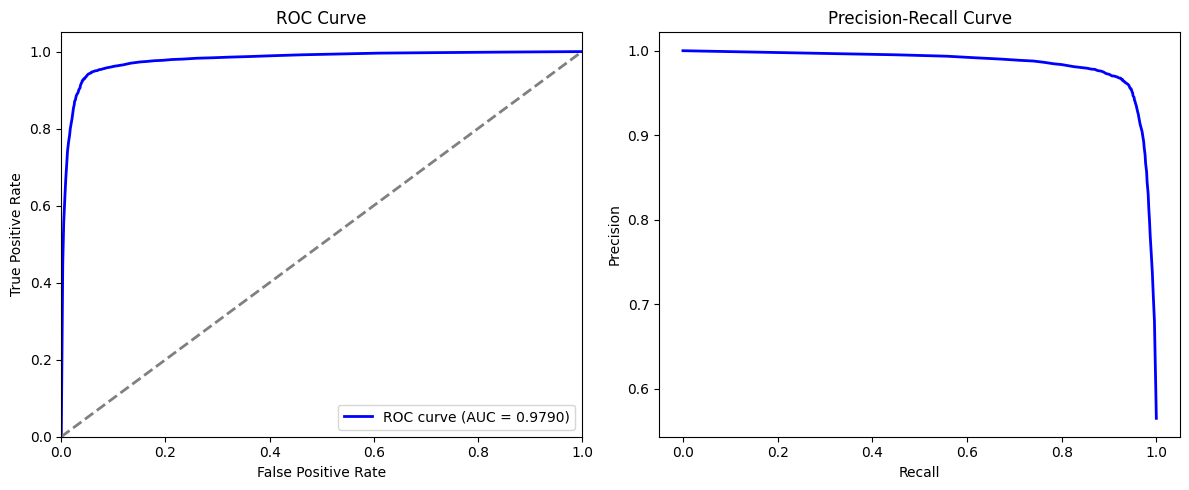

model name: GradientBoostingClassifier


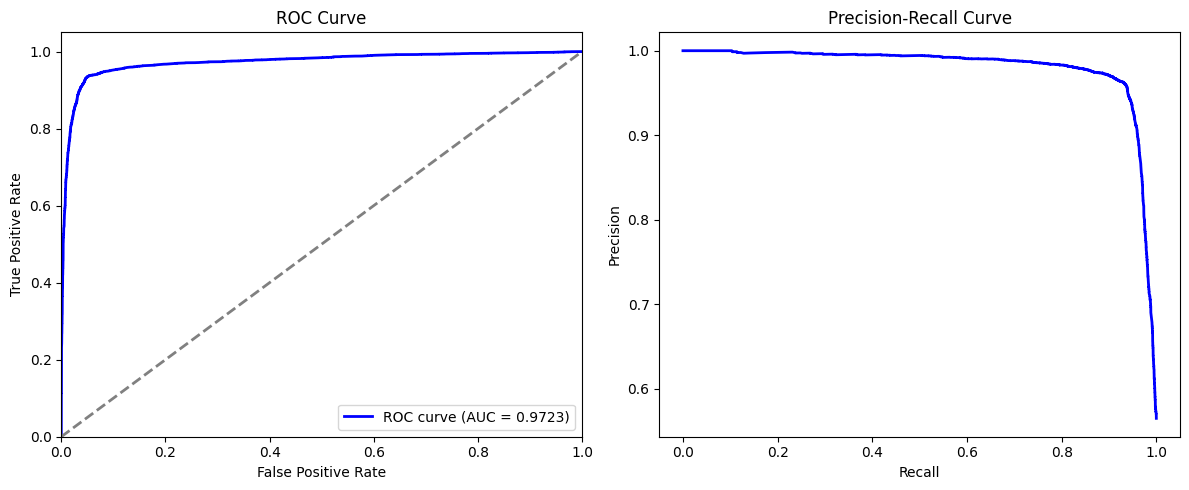

model name: SVC


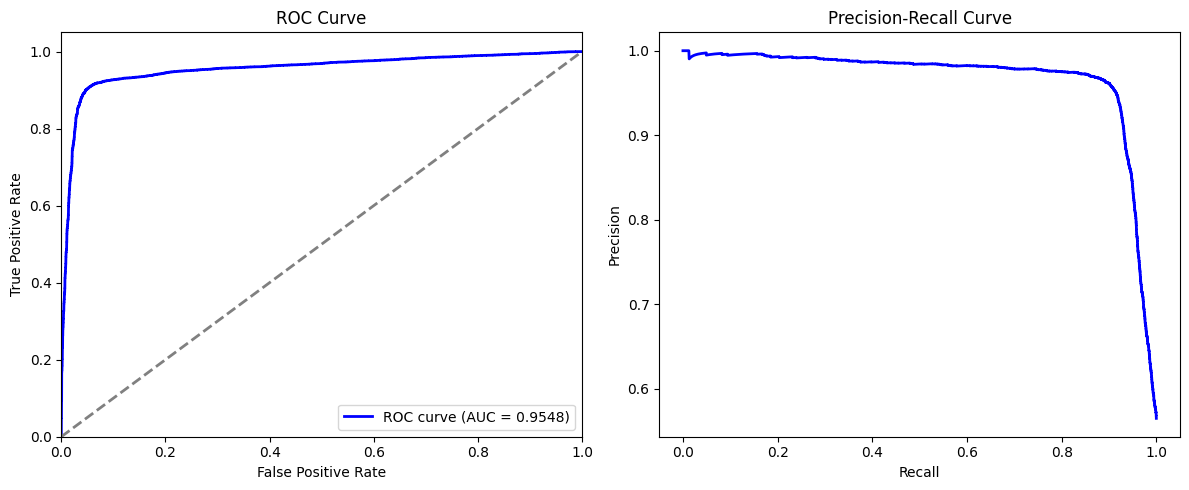

model name: LogisticRegression


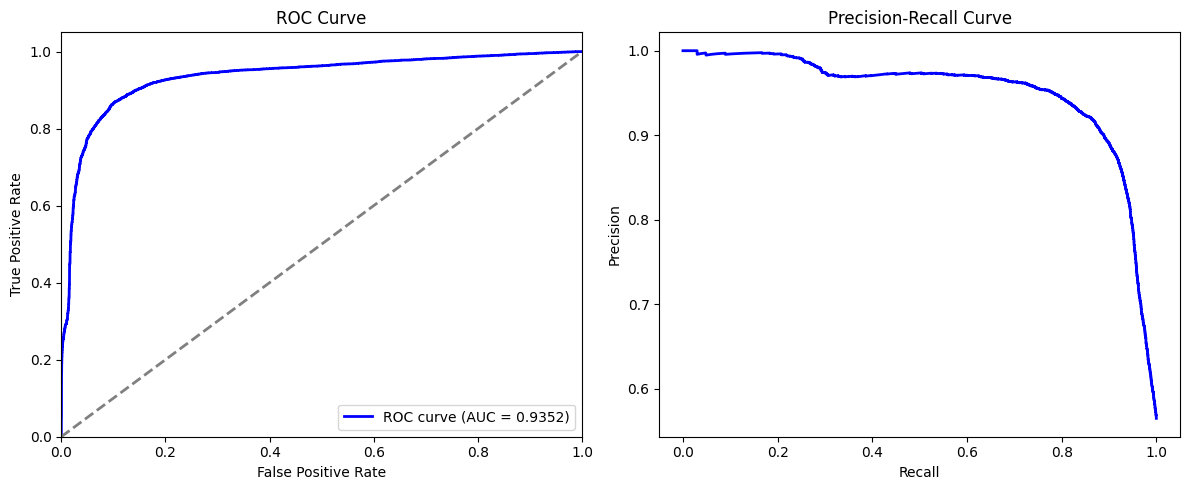

In [38]:
models = [rf_model, gb_model, svm_model, lr_model]
for model in models:
    plot_ROC_PR_curves(model)

# Deep Learning model - Dense Neural Net

In [30]:
features_num = X_train.shape[1]

In [31]:
NN_model = Sequential([
    Input(shape=(features_num,)),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
NN_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Set up EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [32]:
# Training the Model

print("Training the model...")
history = NN_model.fit(X_train, y_train, epochs=50, batch_size=64, validation_split=0.2, callbacks=[early_stopping])

Training the model...
Epoch 1/50
686/686 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7943 - loss: 0.4480 - val_accuracy: 0.8963 - val_loss: 0.2870
Epoch 2/50
686/686 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8947 - loss: 0.3079 - val_accuracy: 0.9089 - val_loss: 0.2647
Epoch 3/50
686/686 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9056 - loss: 0.2831 - val_accuracy: 0.9141 - val_loss: 0.2544
Epoch 4/50
686/686 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9161 - loss: 0.2647 - val_accuracy: 0.9157 - val_loss: 0.2477
Epoch 5/50
686/686 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9173 - loss: 0.2648 - val_accuracy: 0.9216 - val_loss: 0.2401
Epoch 6/50
686/686 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9202 - loss: 0.2525 - val_accuracy: 0.9226 - val_loss: 0.2358
Epoch 7/50
686/686 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9234 - loss: 0.2499 - val_accuracy: 0.9240 - val_loss: 0.2334
Epoch 8/50
686/686 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9252 - loss: 0.2

In [33]:
test_loss, test_acc = NN_model.evaluate(X_test,  y_test, verbose=2)
print('\nTest accuracy NN:', test_acc)

429/429 - 1s - 1ms/step - accuracy: 0.9308 - loss: 0.2193

Test accuracy NN: 0.9308308959007263


In [34]:
# Evaluating the Model

print("Evaluating the model...")
y_pred_train = NN_model.predict(X_train)
y_pred_test = NN_model.predict(X_test)

# Convert probabilities to binary predictions
y_pred_train = (y_pred_train > 0.5).astype(int)
y_pred_test = (y_pred_test > 0.5).astype(int)

def evaluate_model(y_true, y_pred, dataset_type="Test"):
    accuracy = accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f"{dataset_type} Set Evaluation:")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"F1 Score: {f1:.2f}")

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title(f'Confusion Matrix - {dataset_type} Set')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

Evaluating the model...
1715/1715 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


Training Set Evaluation:
Accuracy: 0.93
Recall: 0.94
Precision: 0.94
F1 Score: 0.94


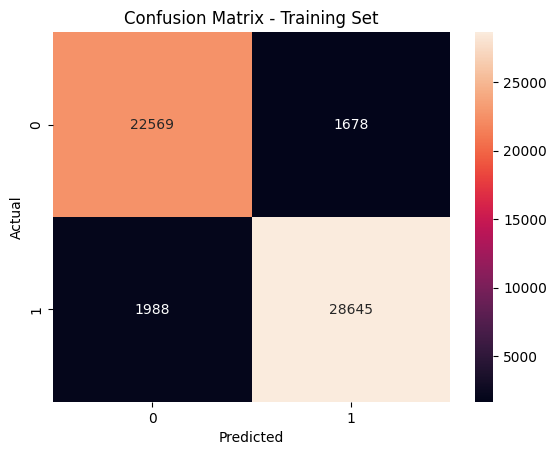

Test Set Evaluation:
Accuracy: 0.93
Recall: 0.93
Precision: 0.95
F1 Score: 0.94


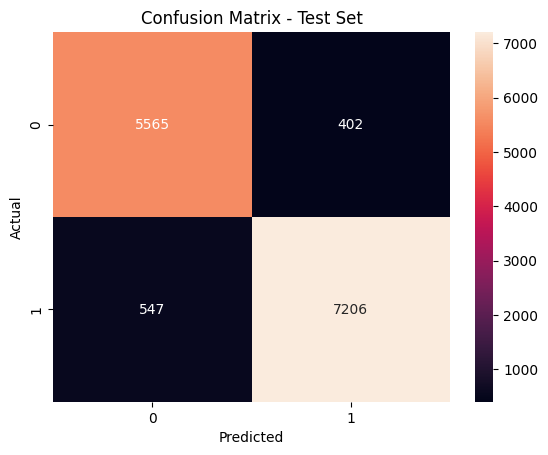

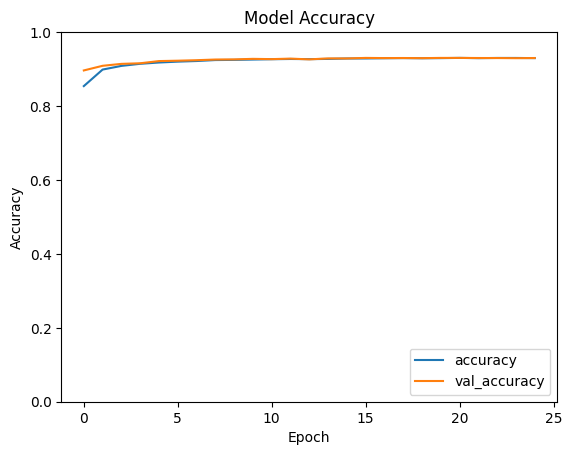

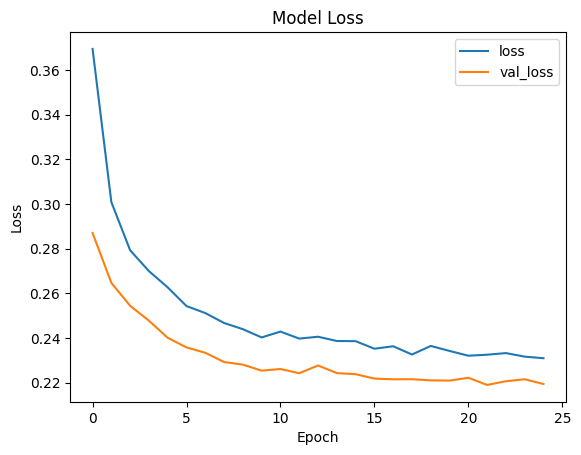

In [35]:
# Evaluate on training set
evaluate_model(y_train, y_pred_train, "Training")

# Evaluate on test set
evaluate_model(y_test, y_pred_test)

# Plotting Training History

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.title('Model Accuracy')
plt.show()

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Model Loss')
plt.show()

model name: Sequential
429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


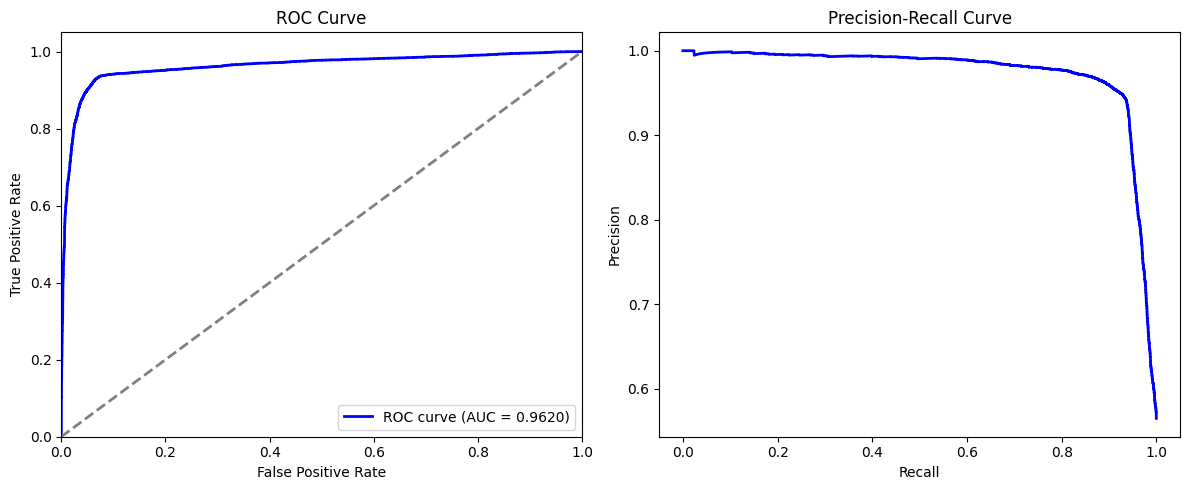

In [41]:
plot_ROC_PR_curves(NN_model)

In [ ]:
# save model 
NN_model.save('../models/dense_neural_net_classifier.keras')